<a href="https://colab.research.google.com/github/Iterb/Human-interaction-recognition/blob/main/Preprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
#http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if True:
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Main imports

In [2]:
import pandas as pd
import numpy as np
from statistics import mean
import math

# Joint features
Load joint data extracted by OpenPose form NTU dataset 

Input data is in format 
(x,y,c) for each of 25 joints concatenated for 2 people. 

In [3]:
full_data = pd.read_csv(r'./drive/MyDrive/OpenPose/full_data.csv')

x = full_data.drop(["class"],axis=1)
y = full_data["class"].values

print('size of x = ',x.shape)
print('size of y = ',y.shape)

x_data_not_normalized = x.copy
y_data_not_normalized = y.copy

size of x =  (6708, 150)
size of y =  (6708,)


Removing c detection confidence values

In [4]:
x  = x.drop(x.columns[2::3], axis=1)

Spliting data

In [5]:
x_per1 = x.drop(x.columns[50:], axis=1)
x_per2 = x.drop(x.columns[:50], axis=1)

In [6]:
x_coords_per1 = []
for x in x_per1.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per1.append(joint_coords)
x_coords_per1 = np.array(x_coords_per1)

x_coords_per2 = []
for x in x_per2.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per2.append(joint_coords)
x_coords_per2 = np.array(x_coords_per2)

Creating new features - limbs length (normalized euclidean distances) and angles.  

         Orginal                            Limbs                          Angles

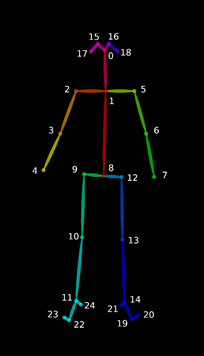 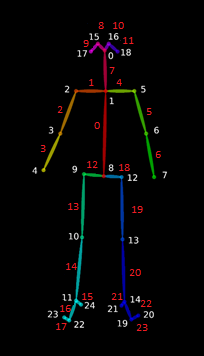 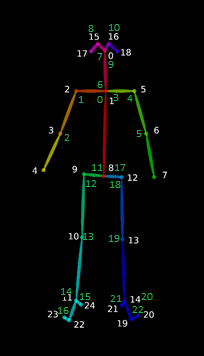


In [55]:
limbs = [(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,0),(0,15),(15,17),(0,16),(16,18),
           (8,9),(9,10),(10,11),(11,24),(11,23),(22,23),(8,12),(12,13),(13,14),
           (14,21),(14,19),(19,20)]

#direction - away from joint number 1 and then from down
angles = [(8,1,2),(1,2,3),(2,3,4),(8,1,5),(1,5,6),(5,6,7),(2,1,0),(1,0,15),(0,15,17),
          (1,0,16),(0,16,18),(1,8,9),(8,9,10),(9,10,11),(10,11,22),(10,11,24),(11,22,23),
          (1,8,12),(8,12,13),(12,13,14),(13,14,19),(13,14,21),(14,19,20)]

def calculate_angle(a, b, c):
  ba = a - b
  bc = c - b
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  return (np.degrees(np.arccos(cosine_angle)) / 180)

def calculate_average_limb_lengths(x_coords):
  x_avg_lengths =[[] for i in range(24)]
  norms = []
  x_avg_lengths[0].append(1)
  for frame in x_coords:
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      continue
    norm = np.linalg.norm(frame[1] - frame[8])
    norms.append(norm)
    l0 = 1
    for i, limb in enumerate(limbs):
      if (np.all(frame[limb[0]] != 0)) and (np.all(frame[limb[1]] != 0)):
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_avg_lengths[i+1].append(l)

  limb_lengths_average = [sum(col)/len(col) for col in x_avg_lengths]
  norm_average = sum(norms)/len(norms)
  return limb_lengths_average, norm_average

def calculate_average_angles(x_coords):
  x_avg_angles =[[] for i in range(23)]
  for frame in x_coords:
    for i, angle in enumerate(angles):
      if (np.all(frame[angle[0]] != 0) and 
         np.all(frame[angle[1]] != 0) and 
         np.all(frame[angle[2]] != 0)):
        
        a = calculate_angle(frame[angle[0]],frame[angle[1]],frame[angle[2]])
        x_avg_angles[i].append(a)
  angles_average = [sum(col)/len(col) for col in x_avg_angles]
  return angles_average

def calculate_limb_lengths(x_coords, average_limbs, average_norm):
  x_lengths = []
  for frame in x_coords:
    x_person = []
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      norm = average_norm
    else:
      norm = np.linalg.norm(frame[1] - frame[8])

    x_person.append(1)
    for i, limb in enumerate(limbs):
      if (np.any(frame[limb[0]] == 0)) or (np.any(frame[limb[1]] == 0)):
        l = average_limbs[i+1]
        x_person.append(l)
      else:
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_person.append(l)

    x_lengths.append(x_person)
  return x_lengths

def calculate_angles(x_coords, average_ang):
  x_angles = []
  for frame in x_coords:
    x_person = []
    for i, angle in enumerate(angles):
      if (np.any(frame[angle[0]] == 0) or 
         np.any(frame[angle[1]] == 0) or 
         np.any(frame[angle[2]] == 0)):
        a = average_ang[i]
        x_person.append(a)
      else:
        a = calculate_angle(frame[angle[0]],frame[angle[1]],frame[angle[2]])
        x_person.append(a)
    x_angles.append(x_person)
  return x_angles

def calculate_2point_distance(x_coords_1, x_coords_2, average_norm):
  x_distance = []
  for frame1, frame2 in zip(x_coords_1,x_coords_2):

    if (np.any(frame1[1] == 0)) or (np.any(frame1[8] == 0)):
      norm = average_norm
    else:
      norm = np.linalg.norm(frame1[1] - frame1[8])

    if (np.any(frame1[1] == 0)) or (np.any(frame2[1] == 0)):
      d = np.linalg.norm(frame1[0] - frame2[0]) / norm
      x_distance.append(d)
    else:
      d = np.linalg.norm(frame1[1] - frame2[1]) / norm
      x_distance.append(d)
  return x_distance


Calculating average limbs and angles. These are used to fill missing values.

In [56]:
average_limbs, average_norm = calculate_average_limb_lengths(x_coords_per1)
average_angles = calculate_average_angles(x_coords_per1)

Calculating new features

In [57]:
x_angles_per1 = calculate_angles(x_coords_per1, average_angles)
x_angles_per2 = calculate_angles(x_coords_per2, average_angles)
x_limbs_per1 = calculate_limb_lengths(x_coords_per1,average_limbs, average_norm)
x_limbs_per2 = calculate_limb_lengths(x_coords_per2,average_limbs, average_norm)
x_distances = calculate_2point_distance(x_coords_per1, x_coords_per2, average_norm)

In [58]:
x_features_per1 = [x + y for x, y in zip(x_angles_per1, x_limbs_per1)]

Creating new dataframes

In [72]:
x_angles_per1_df = pd.DataFrame(x_angles_per1)
x_angles_per2_df = pd.DataFrame(x_angles_per2)
x_limbs_per1_df = pd.DataFrame(x_limbs_per1)
x_limbs_per2_df = pd.DataFrame(x_limbs_per2)
x_distances_df = pd.DataFrame(x_distances)
x_features_typeP = pd.concat([x_angles_per1_df, x_angles_per2_df, x_limbs_per1_df, x_limbs_per2_df, x_distances_df], axis=1)
x_features_typeP.columns = range(0,x_features_typeP.shape[1])


In [73]:
from sklearn.model_selection import train_test_split

y = full_data["class"].values

x_train, x_test, y_train, y_test = train_test_split(x_features_typeP,y,test_size=0.25,shuffle=True)

In [78]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)
print('......')
svm_clf = SVC(random_state=1)
nb_clf = GaussianNB()
nn_clf = MLPClassifier(solver='lbfgs',max_iter=20000)
sgd_clf = SGDClassifier()
rf_clf = RandomForestClassifier(n_estimators=100,random_state=1)

voting_clf = VotingClassifier(
        estimators=[('knn',knn_clf),('svm',svm_clf),('nb',nb_clf),
                    ('NN',nn_clf),('sgd',sgd_clf),('rf',rf_clf)], voting='hard')

from sklearn.metrics import accuracy_score
accuracies = {}
for clf in (knn_clf, svm_clf, nb_clf, nn_clf, sgd_clf, rf_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))
    accuracies[clf.__class__.__name__] = accuracy_score(y_test,y_pred)

......
KNeighborsClassifier 0.8688133571854502
SVC 0.6410256410256411
GaussianNB 0.39713774597495527


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier 0.75551580202743
SGDClassifier 0.4991055456171735
RandomForestClassifier 0.8867024448419797
VotingClassifier 0.8306499701848539


array([array([1, 2, 3]), array([1, 2, 4, 5]), array([1, 2, 4, 5]),
       array([1, 2, 3]), 1, 2, 3], dtype=object)

[1, 2, 3]